# Deep Convolutional GAN
* DCGANs can be used to avoid mode collapse in simple GANs
* Mode collapse is a scenario which occurs if generator tries to output very similar/same images for any input poise
* MNIST data set is used to demonstrate DCGAN

Steps:
1. Load real image dataset
2. Data scaling as per netowrk layer activation function. For tanh activation of generator last layer, preferred data range is -1 to +1
3. Prepare generator and discriminator network keeping deep convolutional layers
4. For training each batch use two phases where
 * in Ph1 : Train only discriminator with real images(labeled as 1) and fake images(labeled as 0) 
 * in Ph2 : Train only generator with fake images (labeled as 1)
 

#### Imports

In [29]:
import numpy as np

In [30]:
import matplotlib.pyplot as plt

## Load MNIST dataset

In [31]:
from tensorflow.keras.datasets import mnist

In [32]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

#### Taking only images with zero label as training gan would need lot of resources

In [33]:
real_image_dataset = X_train[y_train == 0]

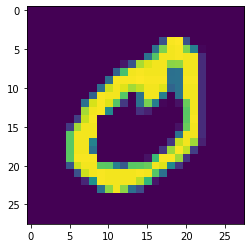

In [34]:
plt.imshow(real_image_dataset[1])

In [35]:
len(real_image_dataset)

5923

In [36]:
single_img_shape = real_image_dataset[0].shape
single_img_shape

(28, 28)

## Scale image data
* As generator last layer uses tanh activation function and generates fake images with data range -1 to 1, try to scale real image data also in the same range

In [37]:
#scale 0 to 1
real_image_dataset = real_image_dataset/255

In [38]:
#scale -1 to +1, since we will be using tanh activation for first network layer
real_image_dataset = 2*real_image_dataset - 1

In [39]:
real_image_dataset.min(), real_image_dataset.max()

(-1.0, 1.0)

#### Reshape the image data adding channels inoformation of convolutional layer

In [40]:
real_image_dataset = np.expand_dims(real_image_dataset, axis = -1)

In [41]:
real_image_dataset.shape

(5923, 28, 28, 1)

In [42]:
img_shape = real_image_dataset.shape[1:]

In [43]:
img_shape

(28, 28, 1)

## Create DCGAN

#### Discriminator

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, LeakyReLU

In [56]:
discriminator = Sequential()
#input shape : 28x28x1
#l1 - output 14x14x64
discriminator.add(Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same', activation = LeakyReLU(0.3), input_shape = img_shape))
discriminator.add(Dropout(0.5))
#l2 - output 7x7x128
discriminator.add(Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same', activation = LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
#l3 - output 6272 (=7x7x128)
discriminator.add(Flatten())
#l4 - output  1
discriminator.add(Dense(1, activation = 'sigmoid'))

#compile discriminator
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam' )
discriminator.trainable = False

In [57]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6273      
Total params: 425,730
Trainable params: 212,865
Non-trainable params: 212,865
__________________________________________

#### Generator
* Try to build generatior network as mirror image of discriminator

In [58]:
from tensorflow.keras.layers import Conv2DTranspose, Reshape

In [59]:
codings_size = 100 # random noise sample size

generator = Sequential()
#input shape : 100
#l1 - output 6272 (=7x7x128)
generator.add(Dense(7*7*128, input_shape = [codings_size]))
#l2 - output 7x7x128
generator.add(Reshape([7,7,128]))
#l3 - output 14x14x64
generator.add(BatchNormalization()) #Normalize and scale inputs or activations.
generator.add(Conv2DTranspose(filters = 64, kernel_size = 5, strides = 2, padding = 'same', activation = LeakyReLU(0.3)))
#l4 - output 28x28x1
generator.add(BatchNormalization()) #Normalize and scale inputs or activations.
generator.add(Conv2DTranspose(filters = 1, kernel_size = 5, strides = 2, padding = 'same', activation = 'tanh'))

In [60]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

#### GAN model

In [61]:
gan = Sequential([generator, discriminator])

In [62]:
gan.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [63]:
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')

## Create batches

In [70]:
batch_size = 32

In [72]:
num_batches = len(real_image_dataset)//batch_size
num_batches

185

In [68]:
import tensorflow as tf

In [82]:
data_slices = tf.data.Dataset.from_tensor_slices(real_image_dataset).shuffle(buffer_size = 100)

In [83]:
img_batches = data_slices.batch(batch_size = batch_size, drop_remainder = True)

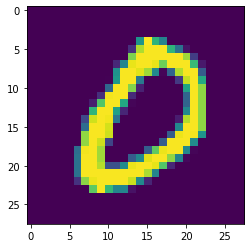

In [84]:
for img_batch in img_batches.take(1):
    plt.imshow(tf.reshape(img_batch[0], (28,28)))

## Train DCGAN

In [104]:
epochs = 10

tf.random.set_seed(101)

for epoch in range(epochs):
    print(f'Current epoch : {epoch + 1}')
    batch_no = 0
    
    for img_batch in img_batches:
        batch_no = batch_no + 1
        if(batch_no % 50 == 0):
            print(f'Current batch : {batch_no} of {num_batches}')
        
        #------- Phase 1 - Train Discriminator -------------
        #Generate random noise for generator input
        noise = tf.random.normal([batch_size , codings_size])
        #Generate fake images
        fake_img_batch = generator(noise)
        #Label fake images as zero and real images as 1
        y_labels = [0]*batch_size + [1]*batch_size
        #Combine fake and real images
        fake_and_real_batch = tf.concat([fake_img_batch, tf.dtypes.cast(img_batch, tf.float32)], axis = 0) 
        #Train only discriminator network
        discriminator.trainable = True
        discriminator.train_on_batch(fake_and_real_batch, y_labels)
        
        #-------- Phase 2 - Train Generator -----------------
        #Generate random noise for generator input
        noise = tf.random.normal([batch_size , codings_size])
        #Label fake images as 1 to confuse discriminator 
        y_labels = [1]*batch_size
        #Train only the generator section in gan
        discriminator.trainable = False
        gan.train_on_batch(noise, y_labels)
        
print('Training complete')

Current epoch : 1
Current batch : 50 of 185
Current batch : 100 of 185
Current batch : 150 of 185
Current epoch : 2
Current batch : 200 of 185
Current batch : 250 of 185
Current batch : 300 of 185
Current batch : 350 of 185
Current epoch : 3
Current batch : 400 of 185
Current batch : 450 of 185
Current batch : 500 of 185
Current batch : 550 of 185
Current epoch : 4
Current batch : 600 of 185
Current batch : 650 of 185
Current batch : 700 of 185
Current epoch : 5
Current batch : 750 of 185
Current batch : 800 of 185
Current batch : 850 of 185
Current batch : 900 of 185
Current epoch : 6
Current batch : 950 of 185
Current batch : 1000 of 185
Current batch : 1050 of 185
Current batch : 1100 of 185
Current epoch : 7
Current batch : 1150 of 185
Current batch : 1200 of 185
Current batch : 1250 of 185
Current epoch : 8
Current batch : 1300 of 185
Current batch : 1350 of 185
Current batch : 1400 of 185
Current batch : 1450 of 185
Current epoch : 9
Current batch : 1500 of 185
Current batch : 15

In [108]:
#Generate random noise for generator input
noise = tf.random.normal([batch_size , codings_size])
#Generate fake images
fake_img_batch = generator(noise)

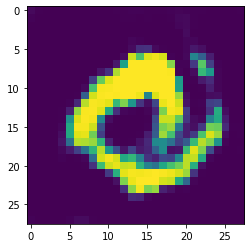

In [109]:
plt.imshow(tf.reshape(fake_img_batch[0], (28,28)))

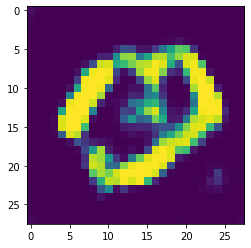

In [110]:
plt.imshow(tf.reshape(fake_img_batch[1], (28,28)))

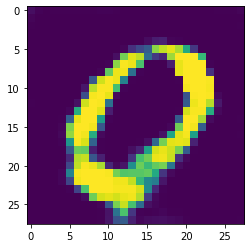

In [111]:
plt.imshow(tf.reshape(fake_img_batch[2], (28,28)))

#### By using DCGAN we can avoid mode collapse

#### Good bye!!